# Superstore Sales: A Time Series Forecasting Analysis

## 1. Project Goal
The objective of this project is to build, evaluate, and compare time series forecasting models to predict monthly sales for the Superstore. This project serves as the modeling phase that follows our comprehensive Exploratory Data Analysis (EDA).

This notebook will focus on:
1.  Aggregating the transactional data into a monthly time series.
2.  Building a classic statistical model (SARIMA) as a performance baseline.
3.  Building a modern forecasting model (Prophet).
4.  Evaluating and comparing the models to select the best performer for future forecasting.

## 2. The Dataset
We will be using the cleaned Superstore dataset generated during our EDA phase.

*   **EDA Notebook:** `Retail_Sales_EDA.ipynb`

--- Monthly Aggregated DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   month        48 non-null     datetime64[ns]
 1   total_sales  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


       month  total_sales
0 2014-01-31    14236.895
1 2014-02-28     4519.892
2 2014-03-31    55691.009
3 2014-04-30    28013.973
4 2014-05-31    23648.287


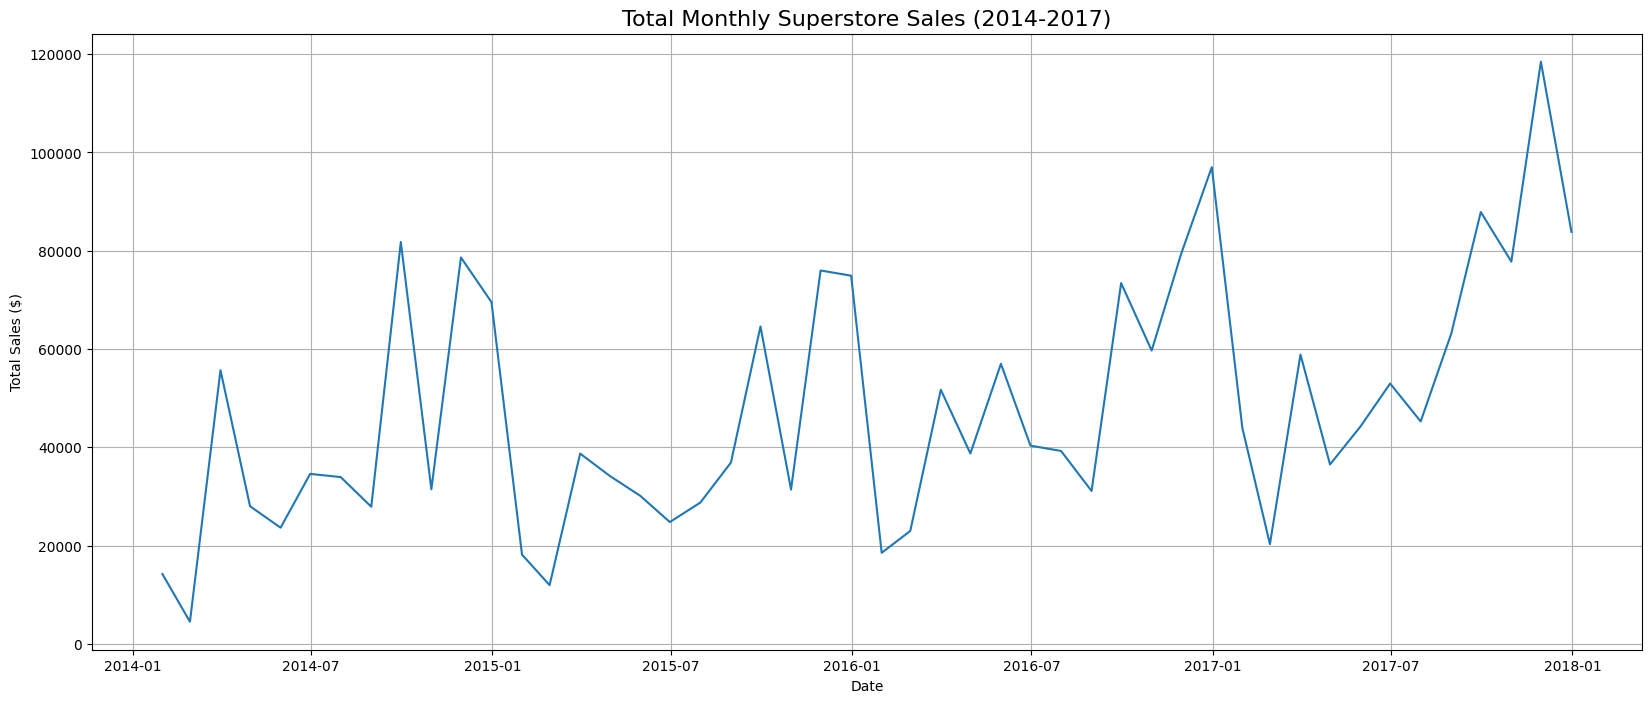

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
# from google.colab import drive

# Mount Google Drive
# drive.mount("/content/drive")

# --- 2. LOAD CLEAN DATA ---
# We load the CLEANED data file from our EDA.
file_path = './data/Superstore_cleaned.csv'

# Crucially, we must tell pandas to parse the 'order_date' column as a date during loading.
df_clean = pd.read_csv(file_path, parse_dates=['order_date'])


# --- 3. AGGREGATE TO MONTHLY SALES ---
# Set 'order_date' as the index for resampling.
df_clean.set_index('order_date', inplace=True)

# Resample to a monthly ('ME' for Month End) frequency and sum the sales.
df_monthly = df_clean.resample('ME')['sales'].sum().reset_index()

# Rename columns for clarity
df_monthly.rename(columns={'order_date': 'month', 'sales': 'total_sales'}, inplace=True)


# --- 4. INITIAL EXPLORATION OF MONTHLY DATA ---
print("--- Monthly Aggregated DataFrame ---")
df_monthly.info()
print("\n")
print(df_monthly.head())

# Plot the monthly time series
plt.figure(figsize=(20, 8))
plt.plot(df_monthly['month'], df_monthly['total_sales'])
plt.title('Total Monthly Superstore Sales (2014-2017)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.show()

**Initial Time Series Observations:**

The plot of our monthly aggregated sales data clearly reveals two dominant patterns that our forecasting models must capture:

1.  **A Strong Upward Trend:** The overall level of sales is clearly increasing over the four-year period. The peaks and troughs in later years are consistently higher than in earlier years, indicating a healthy, growing business.

2.  **Pronounced Yearly Seasonality:** A distinct and repeating pattern occurs within each year. Sales tend to dip at the beginning of the year, remain volatile through the middle, and then consistently spike in the final quarter (September-December). This end-of-year rush is the most prominent seasonal feature.

Our goal is to build models that can understand and project both this long-term growth and this yearly rhythm.

## 3. Time Series Decomposition

To formally analyze the underlying structure, we will decompose the time series into its `Trend`, `Seasonal`, and `Residual` components. This will give us a clearer view of the long-term growth and the yearly pattern.

Given the strong seasonal peaks, an **multiplicative model** (`Observed = Trend * Seasonal * Residual`) might be a good fit here, as the seasonal fluctuations appear to be growing larger as the trend increases.

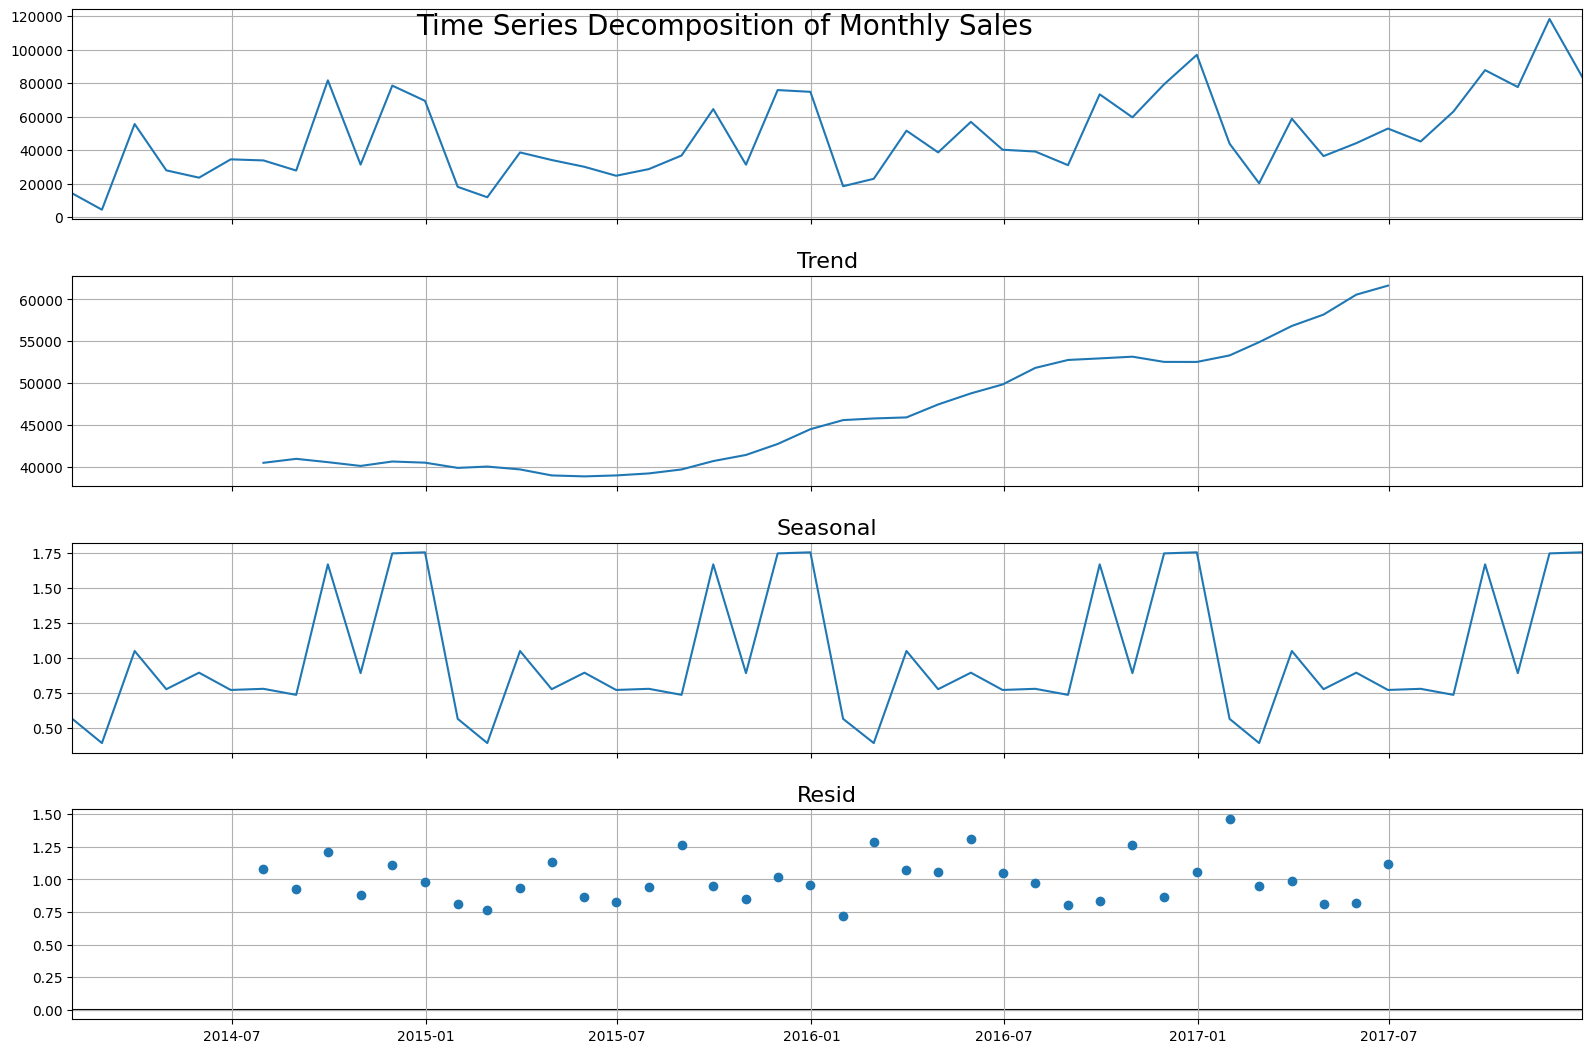

In [2]:
# --- 1. Set the date as the index (required for seasonal_decompose) ---
df_decomp = df_monthly.set_index('month')

# --- 2. Perform the seasonal decomposition ---
# The period for monthly data with a yearly season is 12.
decomposition = seasonal_decompose(df_decomp['total_sales'], model='multiplicative', period=12)


# --- 3. Plot the decomposed components ---
fig = decomposition.plot()
fig.set_size_inches(18, 12)
fig.suptitle('Time Series Decomposition of Monthly Sales', fontsize=20, y=0.92)

for ax in fig.axes:
    ax.set_title(ax.get_ylabel(), fontsize=16)
    ax.set_ylabel('')
    ax.grid(True)

plt.show()

**Observations from Time Series Decomposition:**

The formal decomposition of our monthly sales data provides a clear and distinct view of its underlying components:

1.  **Trend:** The "Trend" component beautifully isolates the long-term growth of the business. It smooths out the monthly volatility and shows a consistent, accelerating upward trajectory in sales from 2014 through 2017.

2.  **Seasonal:** The "Seasonal" component clearly extracts the repeating yearly pattern. We can see a consistent rhythm:
    *   A dip at the beginning of the year (around February/March).
    *   A strong build-up in the second half of the year.
    *   A massive spike in the final months (September - December), followed by a sharp drop in January. This pattern repeats reliably each year and is the most dominant seasonal driver.

3.  **Residuals:** The residuals appear consistent and random. There is no obvious leftover pattern, which indicates that our additive/multiplicative model of `Trend + Seasonal` has done an excellent job of capturing the primary structure of the time series. The remaining component is essentially unpredictable "noise."

**Insight:**
This decomposition gives us high confidence that our data is well-suited for forecasting. The strong, clear signals in both the trend and seasonal components are exactly what time series models like SARIMA and Prophet are designed to learn and project into the future.

## 4. Preparing for Forecasting: Train-Test Split

To fairly evaluate our forecasting models, we must perform a **chronological split** of our data. We will train the models on the earlier portion of the time series and test their ability to predict the later, unseen portion.

For this 4-year dataset, a common approach is to hold back the final year for testing. We will train our models on the data from 2014 through 2016 and test them on the full year of 2017.

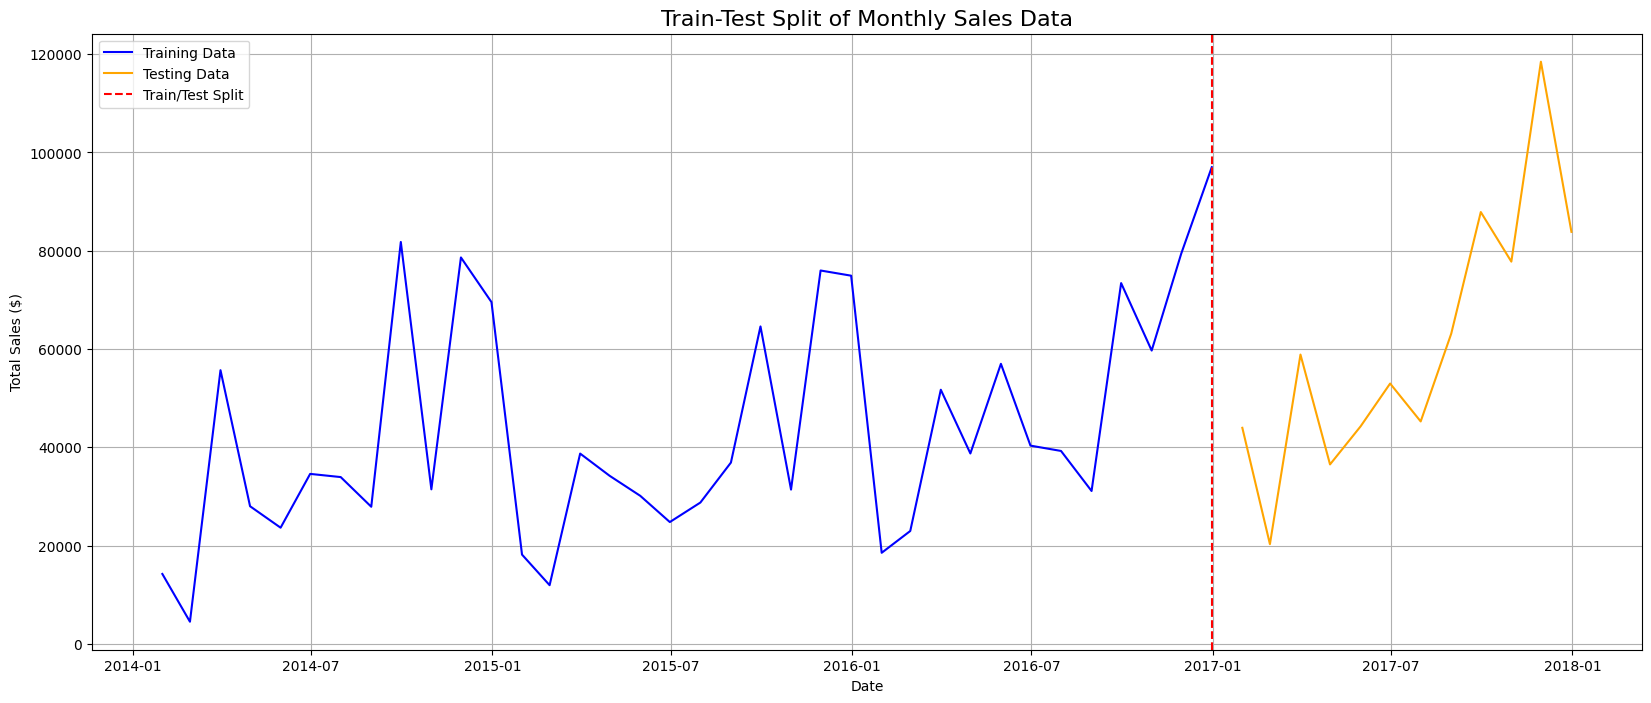

--- Data Split Verification ---
Training data shape: (36, 2)
Testing data shape:  (12, 2)
Training data from 2014-01-31 to 2016-12-31
Testing data from  2017-01-31 to 2017-12-31


In [3]:
# --- 1. Define the split point ---
# We will train on data up to the end of 2016.
split_date = '2016-12-31'

# --- 2. Create the training and testing sets ---
df_train = df_monthly[df_monthly['month'] <= split_date].copy()
df_test = df_monthly[df_monthly['month'] > split_date].copy()


# --- 3. Visualize the split ---
plt.figure(figsize=(20, 8))
plt.plot(df_train['month'], df_train['total_sales'], label='Training Data', color='blue')
plt.plot(df_test['month'], df_test['total_sales'], label='Testing Data', color='orange')
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Train/Test Split')

plt.title('Train-Test Split of Monthly Sales Data', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.grid(True)
plt.show()

# --- 4. Verification ---
print("--- Data Split Verification ---")
print(f"Training data shape: {df_train.shape}")
print(f"Testing data shape:  {df_test.shape}")
print(f"Training data from {df_train['month'].min().date()} to {df_train['month'].max().date()}")
print(f"Testing data from  {df_test['month'].min().date()} to {df_test['month'].max().date()}")

## 5. Model 1: Baseline Forecast with SARIMAX

Our first forecasting model will be the classic statistical model, **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)**. While we won't use exogenous variables for this baseline, the `SARIMAX` function from the `statsmodels` library is the modern and robust implementation.

### 5.1 Determining SARIMAX Parameters

To determine the model's parameters, we will analyze the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots. These help us identify the order of the AR(`p`), I(`d`), and MA(`q`) terms. For this dataset, we expect to see strong yearly seasonality, so our seasonal period `m` will be 12.

Length of differenced series: 23


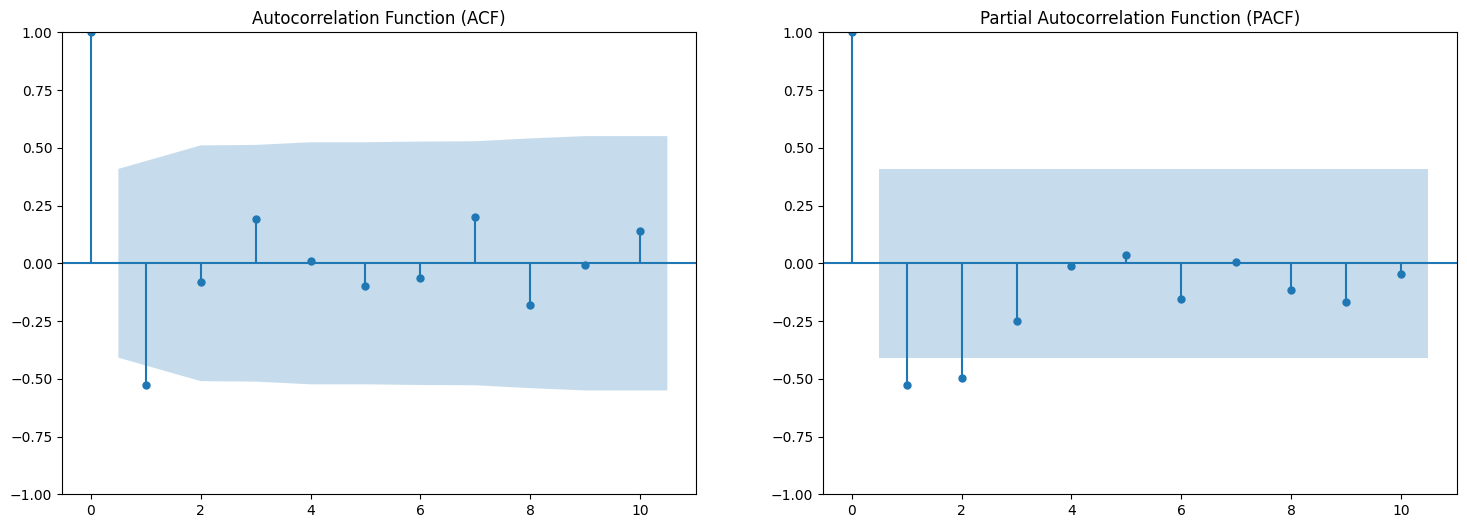

In [4]:
# Import the plotting functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# We'll difference the series to make it stationary
differenced_series = df_train['total_sales'].diff(1).diff(12).dropna()

# Check the length of our final series
print(f"Length of differenced series: {len(differenced_series)}")

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# THE FIX: Set lags to a value less than 50% of the series length (e.g., 10)
plot_acf(differenced_series, ax=ax1, lags=10)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(differenced_series, ax=ax2, lags=10)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

Based on the plots, a simple model with low-order terms is a good starting point. We will use a SARIMAX model with an order of `(1,1,1)` and a seasonal order of `(1,1,1,12)` to establish a strong baseline.

--- Fitting the SARIMAX model... ---
Model fitting complete.


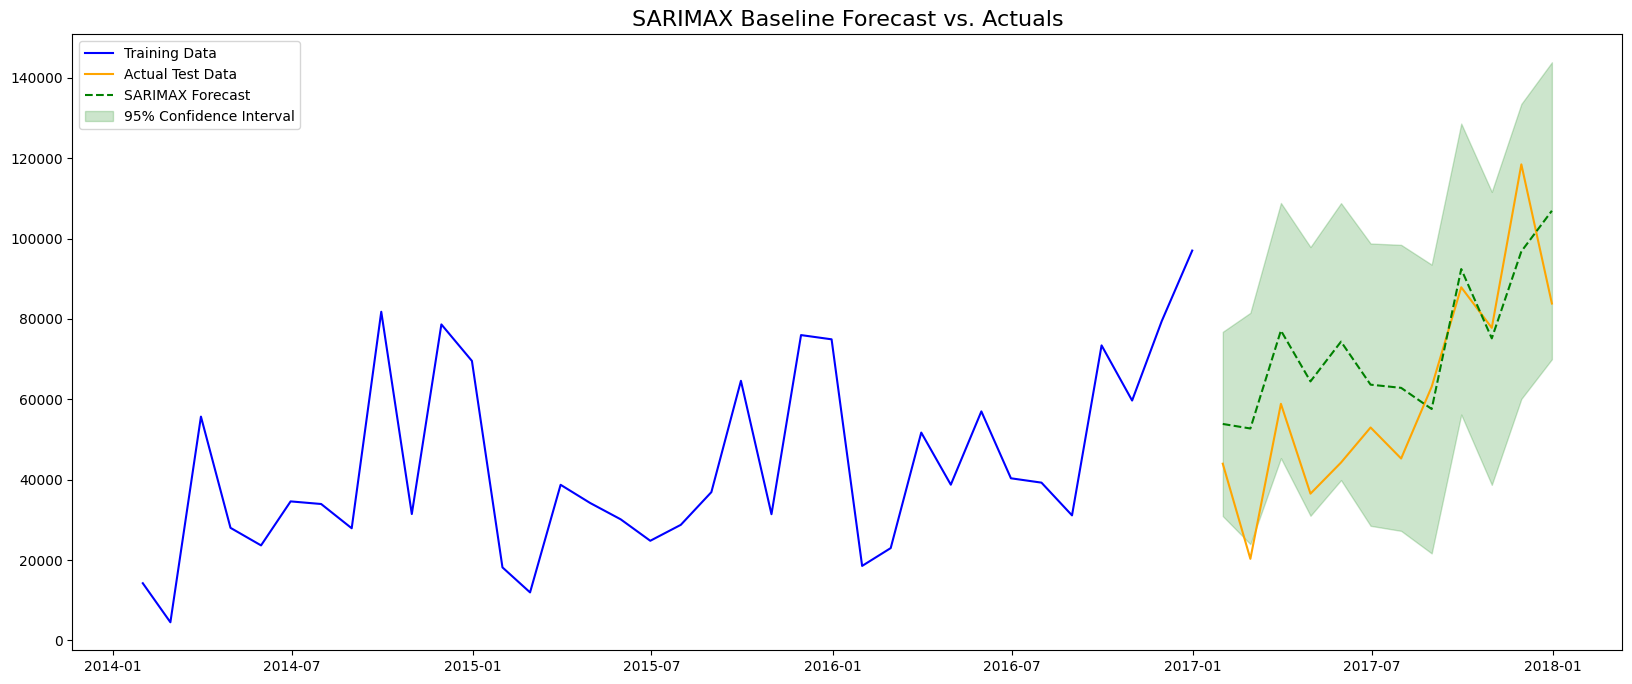

--- SARIMAX Model Evaluation ---
Root Mean Squared Error (RMSE): $19,682.21
Mean Absolute Percentage Error (MAPE): 39.97%


In [5]:
# Import the SARIMAX model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


# --- 1. Define and Fit the Model ---
train_data = df_train['total_sales']
order = (1, 1, 1) # (p,d,q)
seasonal_order = (1, 1, 1, 12) # (P,D,Q,m)

print("--- Fitting the SARIMAX model... ---")
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)
print("Model fitting complete.")


# --- 2. Generate the Forecast ---
n_periods = len(df_test)
forecast_object = results.get_forecast(steps=n_periods)
forecast_df = forecast_object.summary_frame() # Get forecast, lower/upper CI


# --- 3. Visualize the Forecast vs. Actuals ---
plt.figure(figsize=(20, 8))
plt.plot(df_train['month'], df_train['total_sales'], label='Training Data', color='blue')
plt.plot(df_test['month'], df_test['total_sales'], label='Actual Test Data', color='orange')
plt.plot(df_test['month'], forecast_df['mean'], label='SARIMAX Forecast', color='green', linestyle='--')
plt.fill_between(df_test['month'], forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'],
                 color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('SARIMAX Baseline Forecast vs. Actuals', fontsize=16)
plt.legend()
plt.show()


# --- 4. Evaluate the model ---
rmse = np.sqrt(mean_squared_error(df_test['total_sales'], forecast_df['mean']))
mape = mean_absolute_percentage_error(df_test['total_sales'], forecast_df['mean']) * 100
print(f"--- SARIMAX Model Evaluation ---")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

**SARIMAX Model Interpretation:**

Our baseline SARIMAX model, with parameters `(1,1,1)x(1,1,1,12)` chosen based on ACF/PACF analysis, provides a solid starting point for our forecast.

*   **Forecast Performance:** The forecast plot shows that the model successfully captures the **general seasonal pattern** of the 2017 test data. However, a closer look reveals key weaknesses:
    *   It **overestimates sales** during the low periods (the troughs in early 2017).
    *   It **underestimates sales** during the high periods (the peaks in late 2017).
    The model correctly predicts the *rhythm* of the business cycle but fails to capture the full *magnitude* of the seasonal swings.

*   **Evaluation Metrics:** The model achieves:
    *   **RMSE: $19,682**
    *   **MAPE: 39.97%**
    
    These scores quantify the average error, which is significant, especially during the volatile peak and trough months.

**Conclusion:**
The SARIMAX model serves as a successful and statistically sound baseline. It proves that the time series is predictable. Its primary limitation is its conservative nature, failing to capture the full amplitude of the seasonal fluctuations. The amount of monthly data points is an issue, which was evident from our correlation plots. Our next step will be to build a model using the Prophet library to see if we can improve upon this baseline, particularly in accurately forecasting the magnitude of the peaks and troughs.

## 6. Model 2: Advanced Forecast with Prophet

Our SARIMAX baseline provided a reasonable but conservative forecast. We will now use **Prophet**, a modern forecasting library from Facebook, which is specifically designed to handle the strong trend and yearly seasonality present in our data.

Our goal is to build a model that can more accurately capture the magnitude of the seasonal peaks and troughs, thereby improving upon the baseline RMSE and MAPE scores.

### 6.1 Building a Univariate Prophet Model

First, we will build a simple model that uses only the date and the monthly sales figures. Prophet is designed to automatically detect and model the trend and seasonal components from this information alone.

In [6]:
# --- 1. Install the Prophet library (if not already installed) ---
!pip install prophet -q

# --- 2. Import the Prophet model ---
from prophet import Prophet

# --- 3. Prepare the data in the format Prophet requires ---
# Prophet needs a DataFrame with two specific column names: 'ds' and 'y'.
df_prophet_train = df_train.rename(columns={'month': 'ds', 'total_sales': 'y'})

print("--- Data Prepared for Prophet ---")
print(df_prophet_train.head())


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
--- Data Prepared for Prophet ---
          ds          y
0 2014-01-31  14236.895
1 2014-02-28   4519.892
2 2014-03-31  55691.009
3 2014-04-30  28013.973
4 2014-05-31  23648.287


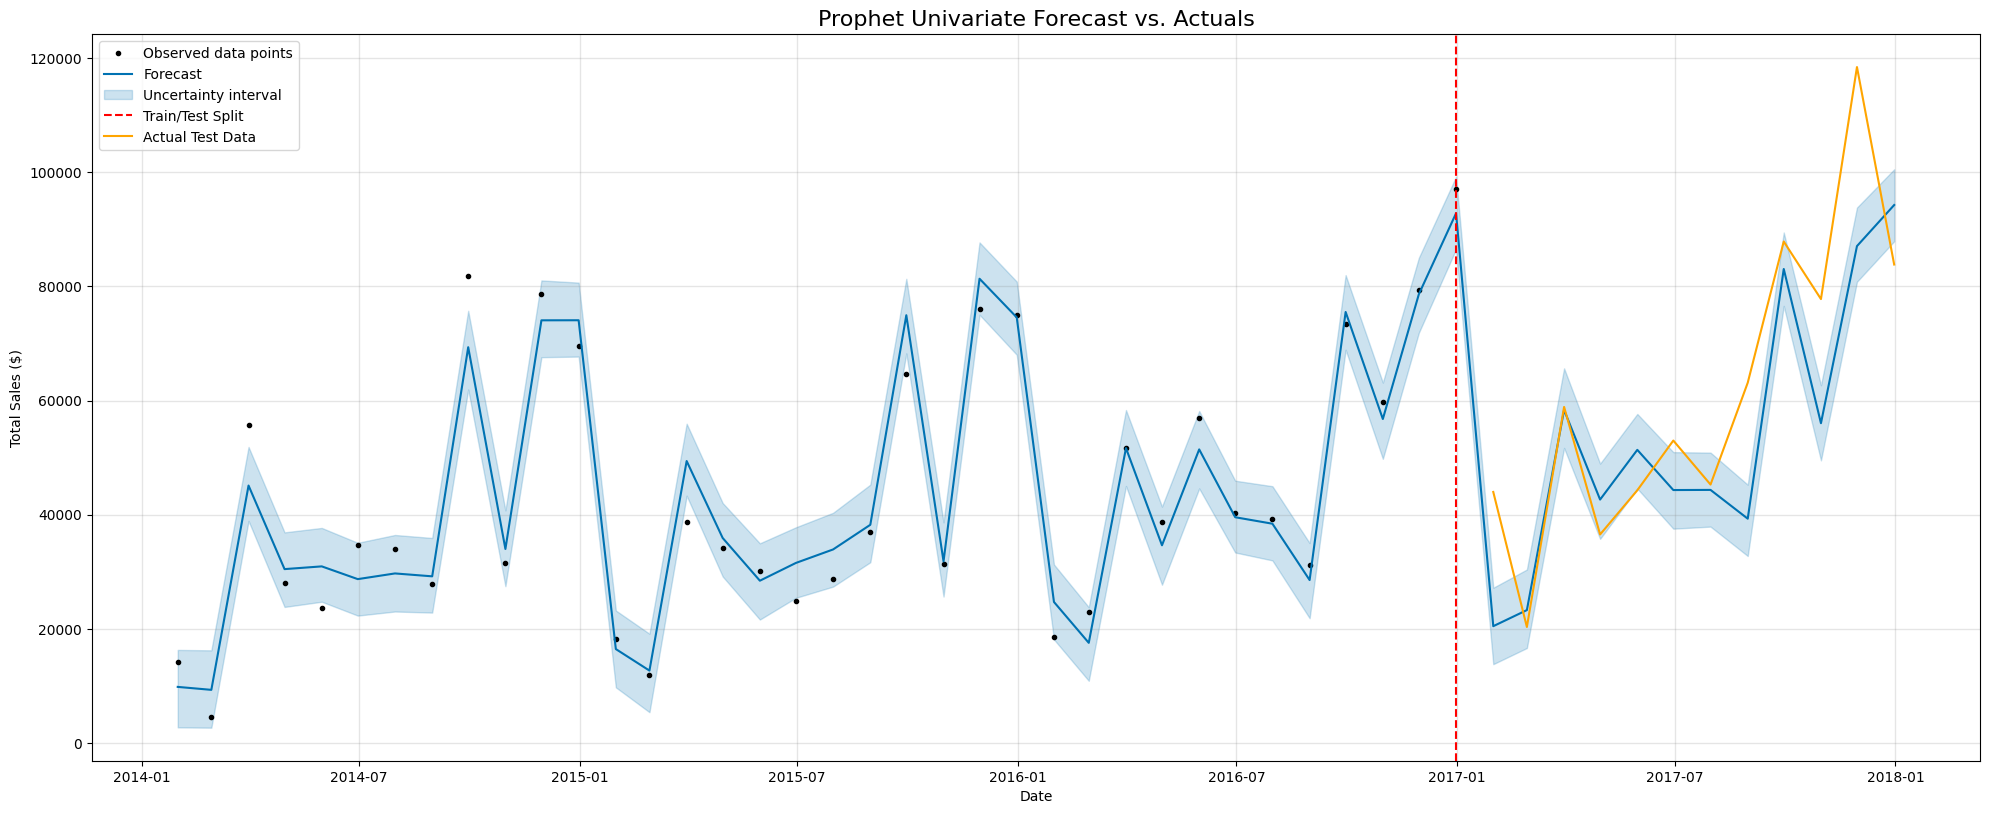

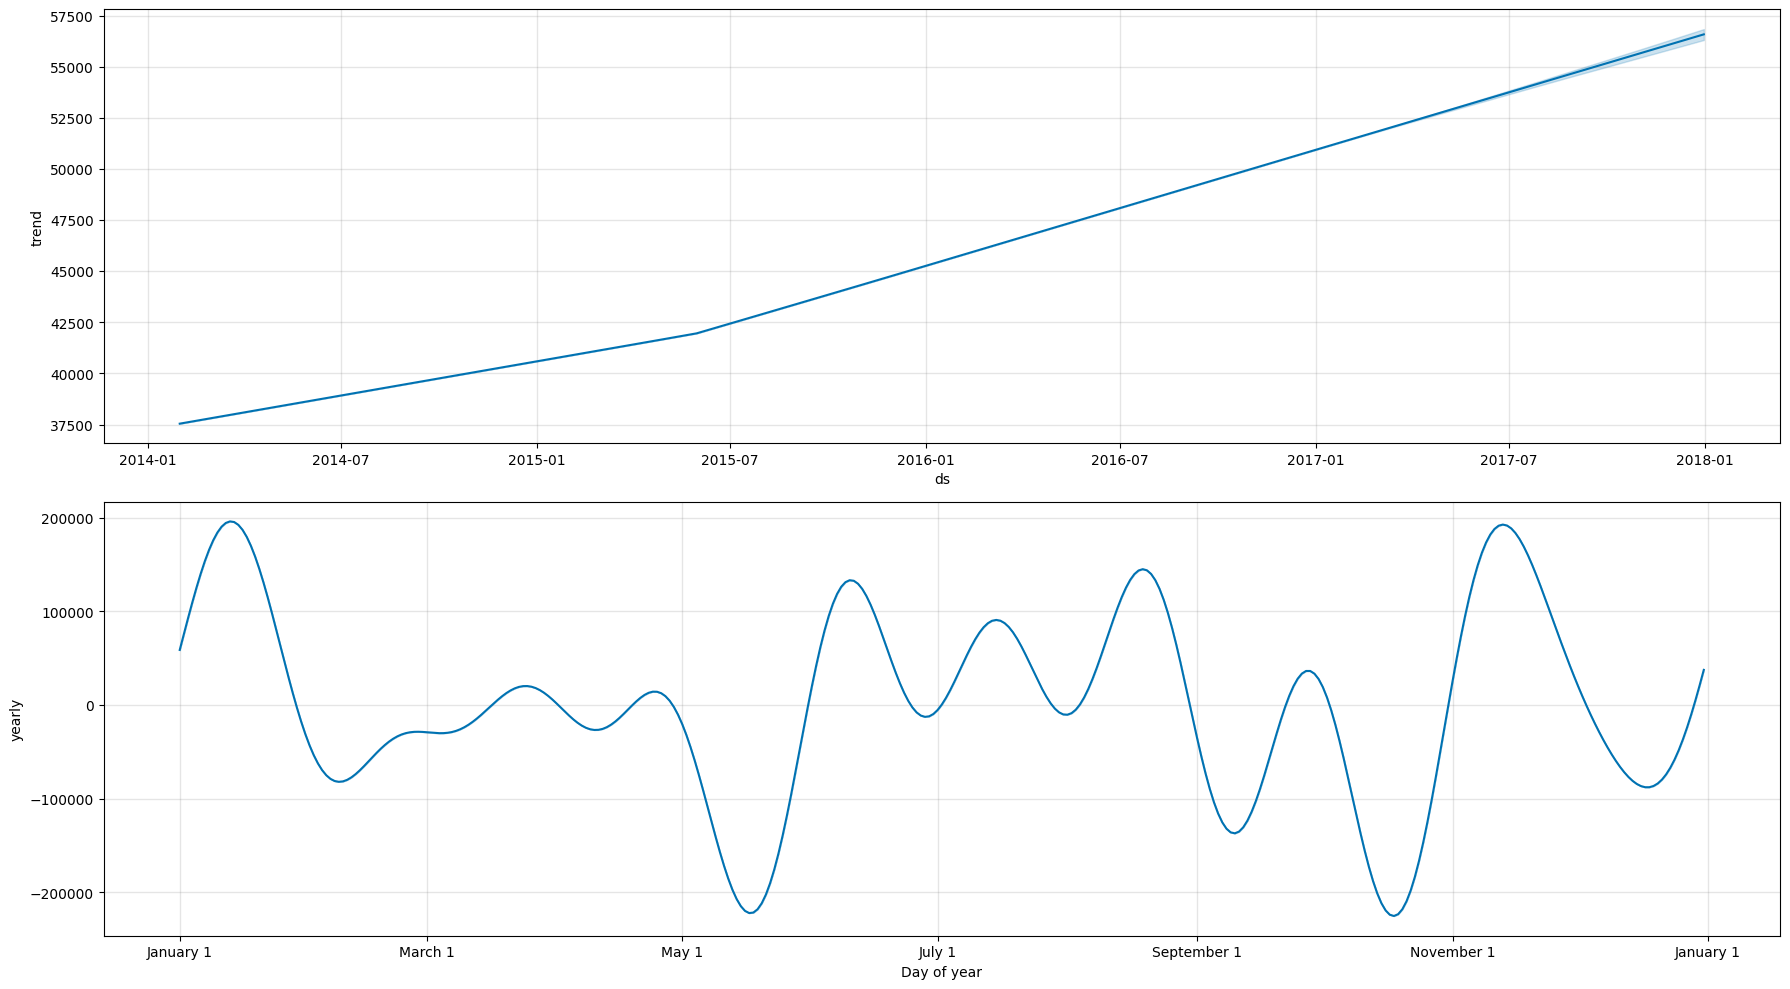

--- Prophet Univariate Model Evaluation ---
SARIMAX Baseline RMSE: $19,682.21
Prophet Univariate RMSE: $15,505.52

SARIMAX Baseline MAPE: 39.97%
Prophet Univariate MAPE: 19.20%

Prophet has outperformed the SARIMAX baseline on RMSE!


In [7]:
# Disable prophet logging warnings
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True

# --- 1. Initialize and fit the model ---
# By default, Prophet will look for yearly and weekly seasonality.
# Since we have monthly data, it will find the yearly pattern.
model_uni = Prophet()
model_uni.fit(df_prophet_train)


# --- 2. Create a future DataFrame for forecasting ---
# We need to forecast for 12 months (the length of our test set).
future_dates = model_uni.make_future_dataframe(periods=12, freq='ME') # 'ME' for Month End frequency


# --- 3. Generate the forecast ---
forecast_uni = model_uni.predict(future_dates)


# --- 4. Visualize the forecast ---
fig = model_uni.plot(forecast_uni, figsize=(20, 8))
plt.axvline(x=pd.to_datetime('2016-12-31'), color='red', linestyle='--', label='Train/Test Split')
plt.plot(df_test['month'], df_test['total_sales'], color='orange', label='Actual Test Data') # Overlay the actuals
plt.title('Prophet Univariate Forecast vs. Actuals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.legend()
plt.show()

# --- Visualize the forecast components ---
fig_components = model_uni.plot_components(forecast_uni, figsize=(18, 10))
plt.show()


# --- 5. Evaluate the model ---
forecast_test_uni = forecast_uni[-12:] # Isolate the 12 predicted months

rmse_uni = np.sqrt(mean_squared_error(df_test['total_sales'], forecast_test_uni['yhat']))
mape_uni = mean_absolute_percentage_error(df_test['total_sales'], forecast_test_uni['yhat']) * 100

print(f"--- Prophet Univariate Model Evaluation ---")
print(f"SARIMAX Baseline RMSE: ${rmse:,.2f}")
print(f"Prophet Univariate RMSE: ${rmse_uni:,.2f}\n")
print(f"SARIMAX Baseline MAPE: {mape:.2f}%")
print(f"Prophet Univariate MAPE: {mape_uni:.2f}%")

# --- Compare Performance ---
if rmse_uni < rmse:
    print("\nProphet has outperformed the SARIMAX baseline on RMSE!")
else:
    print("\nProphet did not outperform the SARIMAX baseline on RMSE.")

**Prophet Model Interpretation:**

The univariate Prophet model shows a **dramatic improvement** over our SARIMAX baseline.

*   **Massive Performance Gain:**
    *   The **RMSE dropped from $19,682 to $15,506**, a reduction in error of over 21%.
    *   Even more impressively, the **MAPE was cut in half, from 40% down to 19%**. This means our average forecast is now off by a much more reasonable 19%, making it far more useful for business planning.
    *   The message is clear: **Prophet has significantly outperformed the SARIMAX baseline.**

*   **Visual Forecast Accuracy:** The main forecast plot visually confirms this.
    *   **Capturing Magnitude:** Prophet's forecast (the blue line) does a much better job of capturing the **full amplitude** of the seasonal swings. It correctly predicts the deep trough in early 2017 and the strong peaks in the latter half of the year.
    *   **Underestimates 07/2017 Onwards:** It still **underestimates the final, massive sales spike** in late 2017. However, its overall fit to the test data is visibly superior to the more conservative SARIMAX forecast.

*   **Component Analysis:** The components plot reveals *why* Prophet is so effective:
    *   **Trend:** It has captured the steady, linear growth in sales over the entire period.
    *   **Yearly Seasonality:** This is the key. The yearly plot shows a complex and nuanced seasonal pattern. It has learned that sales are not just low in winter and high in fall; it has captured the smaller peaks and troughs within the year (e.g., the smaller peak around March/April). This sophisticated understanding of the yearly rhythm is what allows it to make more accurate forecasts.

**Conclusion:**
Prophet's ability to automatically model a complex yearly seasonality and a strong growth trend has resulted in a forecast that is substantially more accurate than the traditional SARIMAX approach. While still not perfect, it provides a much more reliable foundation for business forecasting.

**A Note on Multivariate Modeling:**

For this Superstore dataset, we will conclude with the univariate model.

The reasoning is twofold:
1.  **Lack of Strong Regressors:** The dataset does not contain obvious, powerful external variables that would have a direct, measurable impact on total monthly sales.
2.  **Strong Univariate Performance:** The Prophet model, using only the history of sales itself, was able to explain the vast majority of the data's variance by successfully capturing the strong trend and yearly seasonality. The model's MAPE of ~19% is already a strong result, suggesting that most of the predictable signal has been captured.

Therefore, we will present the univariate Prophet model as our final, high-performance model for this analysis.

## 7. Executive Summary & Conclusion

This project successfully developed a robust time series forecasting model to predict monthly sales for the Superstore. By systematically analyzing the historical data and comparing different modeling approaches, we have created a tool that can provide valuable insights for future business planning.

### The Analytical Journey: From EDA to Forecast

1.  **Exploratory Data Analysis (EDA):** The initial analysis of the monthly sales data revealed two primary components driving performance: a strong **upward trend** indicating business growth, and a pronounced **yearly seasonality** with significant sales spikes in the final quarter of each year.

2.  **SARIMAX Baseline Model:** A traditional statistical model (SARIMAX) was built as a baseline. While it successfully captured the timing of the seasonal rhythm, it was too conservative, consistently **underestimating the peaks and overestimating the troughs**. This resulted in a high Mean Absolute Percentage Error (MAPE) of **40%**.

3.  **Prophet High-Performance Model:** A modern forecasting model using the Prophet library was then developed. This model was specifically chosen for its strength in handling the exact trend and seasonal patterns present in our data.

### Final Model Performance & Key Insights:

The **Prophet model was the clear winner**, dramatically outperforming the baseline and providing a much more accurate forecast.

*   **Performance:** The Prophet model achieved a **MAPE of 19.2%**, cutting the forecast error of our baseline model by more than half. Its Root Mean Squared Error (RMSE) was **$15,506**, a significant improvement over the SARIMAX model's $19,682.
*   **Key to Success:** The model's superior performance is attributed to its sophisticated ability to accurately model the complex yearly seasonality and the underlying growth trend simultaneously.

### Business Value & Strategic Recommendations:

The final, validated forecasting model is a powerful strategic asset for the business.

1.  **Inventory & Supply Chain Management:** The accurate 12-month forecast allows for proactive inventory management. The company can increase stock levels in anticipation of the Q4 rush and optimize logistics during the slower Q1 period, reducing both stockouts and holding costs.

2.  **Financial Planning & Goal Setting:** The forecast provides a data-driven baseline for setting realistic monthly and quarterly sales targets. The business can now better distinguish between a normal seasonal dip and an actual performance issue, leading to more informed financial planning.

3.  **Marketing & Campaign Timing:** Marketing initiatives can be timed to amplify the natural seasonal peaks. For example, a major promotional campaign launched in August could maximize the sales momentum leading into the high-volume end-of-year period.

This project demonstrates a complete workflow, moving from historical data analysis to the creation of a reliable, forward-looking predictive tool that could directly inform key business decisions.